In [27]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [29]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [30]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [31]:
tf.keras.backend.clear_session()

In [32]:
subject = 'Pará - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [33]:
data = pd.read_csv('2003_mo_model_input_PA.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Pará - Desemprego,Pará - Produção de Cimento (t),Pará - Consumo de Cimento (t),Pará - value,Pará - IDH,Pará - PIB - Estadual,Pará - PIB - Construção Civil,Pará - PIB - Per Capita,Pará - PIB - Preços de Mercado
0,2003-1,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,8.348543,49.618560,84.701,0.312867,0.669564,7.776091e+07,4.250430e+06,9.220374,6.851269e+07
1,2003-2,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,8.342554,49.658098,80.221,0.312657,0.669764,7.787181e+07,4.255476e+06,9.225493,6.856365e+07
2,2003-3,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,8.336566,49.906876,76.122,0.311736,0.669963,7.798271e+07,4.260521e+06,9.230612,6.861461e+07
3,2003-4,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,8.330578,49.864305,76.544,0.310493,0.670163,7.809361e+07,4.265566e+06,9.235731,6.866557e+07
4,2003-5,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,8.324589,50.179753,83.445,0.309128,0.670362,7.820451e+07,4.270611e+06,9.240851,6.871652e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.899018,156.442,0.710173,NaN,NaN,NaN,NaN,NaN
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.416567,145.777,0.708384,NaN,NaN,NaN,NaN,NaN
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.559167,139.233,0.706038,NaN,NaN,NaN,NaN,NaN
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.696005,142.025,0.702147,NaN,NaN,NaN,NaN,NaN


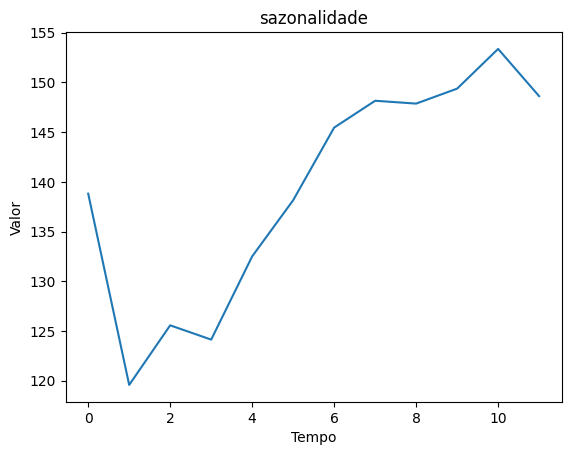

,sazonalidade
sazonalidade,
0,138.809571
1,119.580929
2,125.571250
3,124.136143
4,132.501214
5,138.148500
6,145.449714
7,148.148000
8,147.863071


In [34]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [35]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Pará - Desemprego,Pará - Produção de Cimento (t),Pará - value,Pará - IDH,Pará - PIB - Estadual,Pará - PIB - Construção Civil,Pará - PIB - Per Capita,Pará - PIB - Preços de Mercado,sazonalidade,Pará - Consumo de Cimento (t)
0,2003-1,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,8.348543,49.618560,0.312867,0.669564,7.776091e+07,4.250430e+06,9.220374,6.851269e+07,138.809571,84.701
1,2003-2,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,8.342554,49.658098,0.312657,0.669764,7.787181e+07,4.255476e+06,9.225493,6.856365e+07,119.580929,80.221
2,2003-3,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,8.336566,49.906876,0.311736,0.669963,7.798271e+07,4.260521e+06,9.230612,6.861461e+07,125.571250,76.122
3,2003-4,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,8.330578,49.864305,0.310493,0.670163,7.809361e+07,4.265566e+06,9.235731,6.866557e+07,124.136143,76.544
4,2003-5,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,8.324589,50.179753,0.309128,0.670362,7.820451e+07,4.270611e+06,9.240851,6.871652e+07,132.501214,83.445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.899018,0.710173,NaN,NaN,NaN,NaN,NaN,148.148000,156.442
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.416567,0.708384,NaN,NaN,NaN,NaN,NaN,147.863071,145.777
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.559167,0.706038,NaN,NaN,NaN,NaN,NaN,149.367000,139.233
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.696005,0.702147,NaN,NaN,NaN,NaN,NaN,153.359714,142.025


In [36]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      115.365
1       90.229
2       87.897
3       96.273
4       97.686
        ...   
235        NaN
236        NaN
237        NaN
238        NaN
239        NaN
Name: Pará - Consumo de Cimento (t), Length: 240, dtype: float64

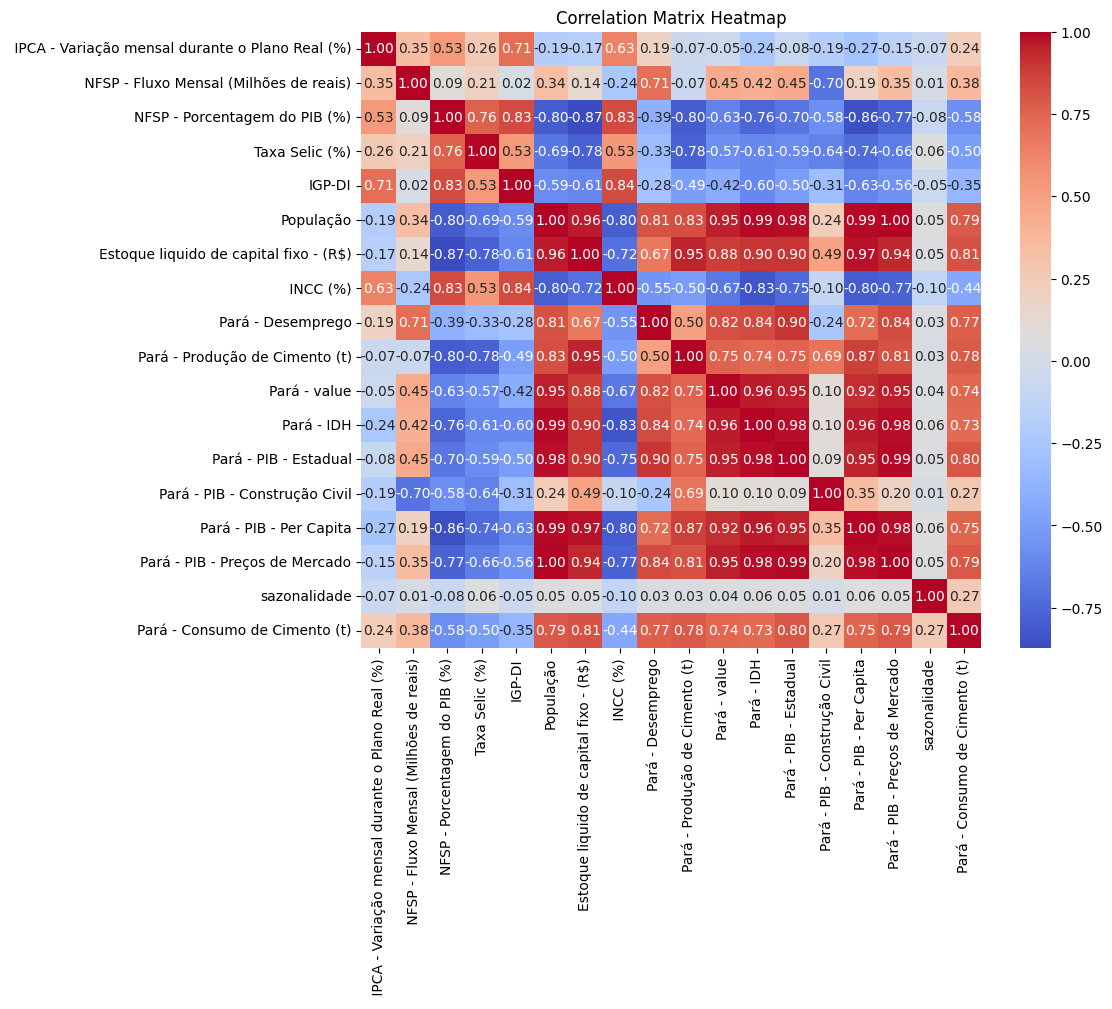

In [37]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [39]:
safe_data = data.fillna(0.0).iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,IPCA - Variação mensal durante o Plano Real (%),8.185564e+02
1,NFSP - Fluxo Mensal (Milhões de reais),4.171659e+02
2,NFSP - Porcentagem do PIB (%),3.056957e+02
3,Taxa Selic (%),5.660934e+01
4,IGP-DI,2.670629e+02
5,População,1.537551e+07
6,Estoque liquido de capital fixo - (R$),9.863207e+06
7,INCC (%),1.876754e+03
8,Pará - Desemprego,1.052419e+04
9,Pará - Produção de Cimento (t),5.861075e+03


In [40]:
data = remove_high_vif_columns(safe_data, 10000000000)
data

Num columns removed: 0


,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Pará - Desemprego,Pará - Produção de Cimento (t),Pará - value,Pará - IDH,Pará - PIB - Estadual,Pará - PIB - Construção Civil,Pará - PIB - Per Capita,Pará - PIB - Preços de Mercado,sazonalidade
0,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,8.348543,49.618560,0.312867,0.669564,7.776091e+07,4.250430e+06,9.220374,6.851269e+07,138.809571
1,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,8.342554,49.658098,0.312657,0.669764,7.787181e+07,4.255476e+06,9.225493,6.856365e+07,119.580929
2,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,8.336566,49.906876,0.311736,0.669963,7.798271e+07,4.260521e+06,9.230612,6.861461e+07,125.571250
3,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,8.330578,49.864305,0.310493,0.670163,7.809361e+07,4.265566e+06,9.235731,6.866557e+07,124.136143
4,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,8.324589,50.179753,0.309128,0.670362,7.820451e+07,4.270611e+06,9.240851,6.871652e+07,132.501214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.366904,-5783.316460,2.206994,0.545067,0.471521,1.987710e+08,7.783063e+06,0.378150,10.250979,91.733516,0.486125,0.695488,9.691241e+07,4.320533e+06,9.650349,7.402227e+07,148.148000
176,0.358935,-6001.730740,2.215328,0.782910,0.476827,1.988450e+08,7.780841e+06,0.377666,10.243000,90.551229,0.486743,0.695498,9.692692e+07,4.321567e+06,9.651274,7.402914e+07,147.863071
177,0.354313,-6454.887704,2.232466,0.909682,0.475427,1.989190e+08,7.778619e+06,0.377838,10.235022,89.566725,0.487330,0.695509,9.694143e+07,4.322601e+06,9.652199,7.403601e+07,149.367000
178,0.352728,-6243.191421,2.263185,1.050614,0.491301,1.989930e+08,7.776397e+06,0.370057,10.227043,88.423018,0.487906,0.695520,9.695594e+07,4.323635e+06,9.653124,7.404288e+07,153.359714


In [41]:
input_data = data.fillna(0.0).iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Pará - Desemprego,Pará - Produção de Cimento (t),Pará - value,Pará - IDH,Pará - PIB - Estadual,Pará - PIB - Construção Civil,Pará - PIB - Per Capita,Pará - PIB - Preços de Mercado
0,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-0.676534,-1.865796,-0.944487,-1.884255,-1.611324,-1.879590,-2.258618,-1.916583
1,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-0.682493,-1.864286,-0.947419,-1.857316,-1.593606,-1.827144,-2.216203,-1.885935
2,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-0.688453,-1.854783,-0.960256,-1.830378,-1.575887,-1.774697,-2.173789,-1.855288
3,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-0.694412,-1.856409,-0.977583,-1.803439,-1.558169,-1.722251,-2.131374,-1.824640
4,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-0.700371,-1.844360,-0.996604,-1.776500,-1.540451,-1.669804,-2.088959,-1.793992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.425789,-0.584804,-1.503380,-0.514871,1.368581,0.605679,-1.872446,1.216746,-0.257106,1.470276,1.616645,1.448487,-1.150848,1.303906,1.397014
176,0.339575,-0.580461,-0.733634,-0.473208,1.380202,0.591420,-1.876611,1.208806,-0.302267,1.478894,1.618091,1.450806,-1.140099,1.311570,1.401144
177,0.160702,-0.571531,-0.323353,-0.484199,1.391823,0.577161,-1.875135,1.200865,-0.339872,1.487076,1.619536,1.453124,-1.129349,1.319233,1.405275
178,0.244264,-0.555524,0.132757,-0.359568,1.403443,0.562902,-1.942040,1.192925,-0.383559,1.495105,1.620982,1.455442,-1.118600,1.326897,1.409405


In [42]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Pará - Desemprego,Pará - Produção de Cimento (t),Pará - value,Pará - IDH,Pará - PIB - Estadual,Pará - PIB - Construção Civil,Pará - PIB - Per Capita,Pará - PIB - Preços de Mercado
0,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-0.676534,-1.865796,-0.944487,-1.884255,-1.611324,-1.879590,-2.258618,-1.916583
1,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-0.682493,-1.864286,-0.947419,-1.857316,-1.593606,-1.827144,-2.216203,-1.885935
2,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-0.688453,-1.854783,-0.960256,-1.830378,-1.575887,-1.774697,-2.173789,-1.855288
3,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-0.694412,-1.856409,-0.977583,-1.803439,-1.558169,-1.722251,-2.131374,-1.824640
4,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-0.700371,-1.844360,-0.996604,-1.776500,-1.540451,-1.669804,-2.088959,-1.793992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.465326,-0.676734,0.472779,-1.087000,1.228701,0.759879,-1.491033,1.388909,0.299109,1.387390,1.567078,1.377835,-1.196945,1.123162,1.280345
164,1.351131,-0.668750,0.302784,-0.904679,1.240408,0.749001,-1.525186,1.365593,0.264159,1.390076,1.574968,1.388721,-1.202774,1.148582,1.297896
165,1.143146,-0.657609,0.339539,-0.900134,1.252114,0.738124,-1.546744,1.342277,0.223045,1.393115,1.582858,1.399606,-1.208604,1.174001,1.315447
166,1.542609,-0.647588,0.472795,-1.136836,1.263821,0.727246,-1.586381,1.318961,0.196722,1.399079,1.590748,1.410491,-1.214433,1.199420,1.332999


In [43]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      115.365
1       90.229
2       87.897
3       96.273
4       97.686
        ...   
163    133.744
164    128.527
165    147.510
166    138.511
167    103.294
Name: Pará - Consumo de Cimento (t), Length: 168, dtype: float64

In [44]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [45]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 15)

In [46]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Pará - Desemprego,Pará - Produção de Cimento (t),Pará - value,Pará - IDH,Pará - PIB - Estadual,Pará - PIB - Construção Civil,Pará - PIB - Per Capita,Pará - PIB - Preços de Mercado
132,0.817451,-0.366715,-0.530011,0.174628,0.848407,0.965586,-0.066954,1.210055,0.853345,0.700824,0.700043,0.935321,0.389528,0.648044,0.835408
133,1.130195,-0.350285,-0.532694,0.240832,0.861179,0.962419,-0.130652,1.234358,0.827697,0.734205,0.704452,0.951749,0.327347,0.656105,0.847461
134,1.160498,-0.335122,-0.186421,0.176857,0.873950,0.959252,-0.079602,1.258661,0.817693,0.767990,0.708860,0.968178,0.265165,0.664167,0.859513
135,1.131990,-0.321950,-0.719664,-0.005233,0.886722,0.956085,-0.034473,1.282964,0.807485,0.804399,0.713268,0.984606,0.202984,0.672229,0.871566
136,1.384387,-0.302995,-0.798520,0.097576,0.899493,0.952918,-0.177535,1.307268,0.797174,0.840691,0.717677,1.001035,0.140803,0.680291,0.883619
137,1.375487,-0.290554,-0.612129,0.431487,0.912265,0.949751,-0.208868,1.331571,0.786599,0.877664,0.722085,1.017463,0.078622,0.688353,0.895671
138,1.438928,-0.281926,-0.476740,0.482414,0.925036,0.946584,-0.245300,1.355874,0.775874,0.914287,0.726493,1.033891,0.016441,0.696414,0.907724
139,1.569590,-0.275931,-0.211736,0.657043,0.937808,0.943417,-0.333490,1.380177,0.764971,0.951937,0.730901,1.050320,-0.045741,0.704476,0.919776
140,1.584058,-0.271466,-0.484608,0.678386,0.950580,0.940250,-0.296846,1.404480,0.754149,0.987464,0.735310,1.066748,-0.107922,0.712538,0.931829
141,1.166380,-0.273241,-0.183907,0.727143,0.963351,0.937082,-0.292462,1.428783,0.743512,1.017299,0.739718,1.083177,-0.170103,0.720600,0.943882


In [47]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 15)

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(36, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(36, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
def predictor(model, test_input, test_target, start_target):
    
    predictions = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        if (prediction[0][0] < 0.0):
            return None, None, None
        predictions.append(prediction[0][0])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    mape = np.mean(df_results["Error"])/np.mean(df_results["Target"])

    return df_results, predictions, mape

In [51]:
def statistical_validator(train_input, train_target, test_input, test_target, start_target):
    
    pd.set_option('display.max_columns', None)
    predictions_list = []
    error_percent = []
    
    i = 0
    while i < 10:
        winner_seed = get_a_good_seed(train_input, train_target, test_input, test_target)
        trained_model, history = lstm_model(train_input, 
                                            train_target, 
                                            want_verbose=0, 
                                            seed=winner_seed)
        df_results, predictions, mape = predictor(trained_model, 
                                            test_input, 
                                            test_target, 
                                            start_index)
        if predictions is not None:
            display(f"\n\Results: {i} ___________________________________________\n")
            display(df_results.T)
            display(mape)
            predictions_list.append(predictions)
            i += 1
        
    predictions_means = np.mean(predictions_list, axis=0)
    results_data = []
   
    for j in range(12):
        target = test_target[start_target + j]
        error = np.abs(predictions_means[j] - target)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                            predictions_means[j], 
                            target, 
                            error])
    display("FINAL___________________________________________________________________")
    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    display(df_results.T)
        
    mae_mean = np.mean(predictions_means)
    mape_mean = np.mean(error_percent) 

    return mae_mean, mape_mean

In [52]:
mae, mape = statistical_validator(reshaped_train, 
                                  reshaped_target, 
                                  reshaped_test, 
                                  reshaped_test_target, 
                                  start_index)

[1974660011, 1661050101, 461147972, 3980279322, 2015085230, 1639621873, 447168461, 3293461862, 1533314240, 1437806973]


Step: 0 ___________________________________________
val_loss: 584.2647094726562
winner_seed: 1974660011


Step: 1 ___________________________________________
val_loss: 1893593.25


Step: 2 ___________________________________________
val_loss: 733.07080078125


Step: 3 ___________________________________________
val_loss: 9017250816.0


Step: 4 ___________________________________________
val_loss: 630.2156982421875


Step: 5 ___________________________________________
val_loss: 861.4964599609375


Step: 6 ___________________________________________
val_loss: 1142.91796875


Step: 7 ___________________________________________
val_loss: 668.7964477539062


Step: 8 ___________________________________________
val_loss: 1138.00732421875


Step: 9 ___________________________________________
val_loss: 1095.678466796875
1/1 [==============================] - 0s 14ms/step


'\n\\Results: 0 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,110.513817,111.137497,111.057724,110.970253,111.099091,111.397575,110.795845,111.464714,111.831688,111.241356,110.995995,110.842979
Target,110.704,91.638,90.744,82.108,97.49,96.803,118.687,109.761,120.188,131.62,125.374,115.811
Error,0.190186,19.499496,20.313721,28.862251,13.609093,14.594574,7.891151,1.703712,8.356316,20.378639,14.378006,4.968018


0.11987126065788678

[2784446822, 1217909871, 1702445804, 982328350, 761228704, 2490719218, 1629768080, 4273448068, 3979881297, 670252756]


Step: 0 ___________________________________________
val_loss: 545.8641967773438
winner_seed: 2784446822


Step: 1 ___________________________________________
val_loss: 1181.822021484375


Step: 2 ___________________________________________
val_loss: 513.8489379882812
winner_seed: 1702445804


Step: 3 ___________________________________________
val_loss: 758.8223876953125


Step: 4 ___________________________________________
val_loss: 1461.0848388671875


Step: 5 ___________________________________________
val_loss: 2979.20458984375


Step: 6 ___________________________________________
val_loss: 341.042724609375
winner_seed: 1629768080


Step: 7 ___________________________________________
val_loss: 896.9480590820312


Step: 8 ___________________________________________
val_loss: 892.4776611328125


Step: 9 ___________________________________________
val_loss: 920460608

'\n\\Results: 1 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,109.004288,109.515686,107.059677,109.765991,111.62085,114.984695,110.453232,116.341797,123.329681,117.647522,115.109955,109.91925
Target,110.704,91.638,90.744,82.108,97.49,96.803,118.687,109.761,120.188,131.62,125.374,115.811
Error,1.699715,17.877686,16.315674,27.65799,14.130852,18.181694,8.233765,6.580795,3.141678,13.972473,10.264046,5.891747


0.1115074767391247

[3326076042, 3548526434, 802535160, 1068332429, 635341802, 4274818099, 3868864156, 3213114921, 1290344691, 214593669]


Step: 0 ___________________________________________
val_loss: 641.2857666015625
winner_seed: 3326076042


Step: 1 ___________________________________________
val_loss: 6722521.5


Step: 2 ___________________________________________
val_loss: 514.303466796875
winner_seed: 802535160


Step: 3 ___________________________________________
val_loss: 603.38818359375


Step: 4 ___________________________________________
val_loss: 514.3148193359375


Step: 5 ___________________________________________
val_loss: 1100.43212890625


Step: 6 ___________________________________________
val_loss: 547.9093017578125


Step: 7 ___________________________________________
val_loss: 768.7564697265625


Step: 8 ___________________________________________
val_loss: 1442.2799072265625


Step: 9 ___________________________________________
val_loss: 580.2085571289062
1/1 [=====================

'\n\\Results: 2 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,121.336037,123.537376,123.998695,123.508507,126.069061,128.350769,127.554771,130.396561,131.131226,129.302872,129.09491,129.370132
Target,110.704,91.638,90.744,82.108,97.49,96.803,118.687,109.761,120.188,131.62,125.374,115.811
Error,10.632034,31.899376,33.254692,41.400505,28.579063,31.547768,8.867775,20.635559,10.943222,2.317123,3.720909,13.559135


0.18386553712134254

[1148225332, 339717917, 3106029358, 1009428009, 2582129835, 1124785783, 3078064325, 3857481634, 34797428, 2218388796]


Step: 0 ___________________________________________
val_loss: 657.888916015625
winner_seed: 1148225332


Step: 1 ___________________________________________
val_loss: 753.4428100585938


Step: 2 ___________________________________________
val_loss: 1118.296875


Step: 3 ___________________________________________
val_loss: 546.7227783203125
winner_seed: 1009428009


Step: 4 ___________________________________________
val_loss: 1141.8634033203125


Step: 5 ___________________________________________
val_loss: 701.5087890625


Step: 6 ___________________________________________
val_loss: 296.8876953125
winner_seed: 3078064325


Step: 7 ___________________________________________
val_loss: 606.2105712890625


Step: 8 ___________________________________________
val_loss: 206.54299926757812
winner_seed: 34797428


Step: 9 ___________________________________________
val_los

'\n\\Results: 3 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,129.147461,131.211197,128.683533,128.669861,128.304825,125.324814,130.217575,123.362511,129.127289,126.111008,125.984848,125.751289
Target,110.704,91.638,90.744,82.108,97.49,96.803,118.687,109.761,120.188,131.62,125.374,115.811
Error,18.443459,39.573196,37.939529,46.561859,30.814827,28.521812,11.530579,13.601509,8.939285,5.508987,0.610847,9.940292


0.1951976815507339

[1227180707, 3054399461, 2135450971, 925485770, 139636991, 3518260159, 2221058897, 167970486, 188606476, 1681207159]


Step: 0 ___________________________________________
val_loss: 295.41851806640625
winner_seed: 1227180707


Step: 1 ___________________________________________
val_loss: 303.32159423828125


Step: 2 ___________________________________________
val_loss: 996.4356689453125


Step: 3 ___________________________________________
val_loss: 907.4029541015625


Step: 4 ___________________________________________
val_loss: 691.2947387695312


Step: 5 ___________________________________________
val_loss: 934.6690673828125


Step: 6 ___________________________________________
val_loss: 362.0428466796875


Step: 7 ___________________________________________
val_loss: 522.9312744140625


Step: 8 ___________________________________________
val_loss: 572.677978515625


Step: 9 ___________________________________________
val_loss: 539.166015625
1/1 [==============================] - 0s 

'\n\\Results: 4 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,142.488892,164.433716,166.109436,164.41037,166.536819,172.029846,154.852448,154.006378,166.462616,157.938995,146.984833,134.621429
Target,110.704,91.638,90.744,82.108,97.49,96.803,118.687,109.761,120.188,131.62,125.374,115.811
Error,31.784889,72.795715,75.365433,82.302368,69.046822,75.226845,36.165451,44.245377,46.274612,26.319,21.610832,18.810432


0.46474146440780517

[3481976236, 3914058095, 2599676293, 3708262161, 143861174, 3420289633, 3269867024, 363531619, 2361975444, 330065820]


Step: 0 ___________________________________________
val_loss: 1154.8599853515625
winner_seed: 3481976236


Step: 1 ___________________________________________
val_loss: 617.17919921875
winner_seed: 3914058095


Step: 2 ___________________________________________
val_loss: 525.7640380859375
winner_seed: 2599676293


Step: 3 ___________________________________________
val_loss: 520.229248046875
winner_seed: 3708262161


Step: 4 ___________________________________________
val_loss: 819.0985107421875


Step: 5 ___________________________________________
val_loss: 1544.9005126953125


Step: 6 ___________________________________________
val_loss: 728.9475708007812


Step: 7 ___________________________________________
val_loss: 533.6219482421875


Step: 8 ___________________________________________
val_loss: 3141947.25


Step: 9 ___________________________________________
va

'\n\\Results: 5 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,119.603661,123.275818,123.023376,123.886772,125.817535,129.146439,123.364975,129.919922,137.252289,134.871719,133.374496,129.386826
Target,110.704,91.638,90.744,82.108,97.49,96.803,118.687,109.761,120.188,131.62,125.374,115.811
Error,8.899658,31.637817,32.279373,41.77877,28.327538,32.343437,4.677979,20.15892,17.064285,3.251724,8.000496,13.575829


0.1874588100352548

[3096828584, 2343040309, 3373030386, 295102483, 3459630636, 813800136, 3103161394, 3159667234, 1561540955, 3022969695]


Step: 0 ___________________________________________
val_loss: 590.9747314453125
winner_seed: 3096828584


Step: 1 ___________________________________________
val_loss: 524.23193359375
winner_seed: 2343040309


Step: 2 ___________________________________________
val_loss: 274616256.0


Step: 3 ___________________________________________
val_loss: 999.3087158203125


Step: 4 ___________________________________________
val_loss: 426.3330993652344
winner_seed: 3459630636


Step: 5 ___________________________________________
val_loss: 1362.606201171875


Step: 6 ___________________________________________
val_loss: 16957.51171875


Step: 7 ___________________________________________
val_loss: 508.338623046875


Step: 8 ___________________________________________
val_loss: 556.0062255859375


Step: 9 ___________________________________________
val_loss: 601.91162109375
1/1

'\n\\Results: 6 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,122.799278,124.957031,126.302551,124.690056,128.013107,126.902061,125.140594,119.913322,122.127937,124.454758,122.744377,120.245598
Target,110.704,91.638,90.744,82.108,97.49,96.803,118.687,109.761,120.188,131.62,125.374,115.811
Error,12.095276,33.319031,35.558548,42.582054,30.523109,30.09906,6.453598,10.152321,1.939934,7.165237,2.629623,4.434601


0.168059256757557

[3230648351, 1695085185, 1403494135, 3134764919, 1603679709, 2768907365, 2775033696, 483282005, 1098119464, 1985167162]


Step: 0 ___________________________________________
val_loss: 1134.6292724609375
winner_seed: 3230648351


Step: 1 ___________________________________________
val_loss: 4178385509023744.0


Step: 2 ___________________________________________
val_loss: 505.6265563964844
winner_seed: 1403494135


Step: 3 ___________________________________________
val_loss: 516.7974243164062


Step: 4 ___________________________________________
val_loss: 532.18017578125


Step: 5 ___________________________________________
val_loss: 27388141568.0


Step: 6 ___________________________________________
val_loss: 597.9075317382812


Step: 7 ___________________________________________
val_loss: 843.8229370117188


Step: 8 ___________________________________________
val_loss: 940.48388671875


Step: 9 ___________________________________________
val_loss: 1749.049560546875
1/1 [=============

'\n\\Results: 7 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,118.771652,123.962151,121.022308,121.172981,123.38031,130.497726,120.452103,134.124191,133.166473,125.91983,124.74292,122.886505
Target,110.704,91.638,90.744,82.108,97.49,96.803,118.687,109.761,120.188,131.62,125.374,115.811
Error,8.06765,32.32415,30.278305,39.06498,25.890312,33.694725,1.765106,24.36319,12.97847,5.700165,0.631081,7.075508


0.1718404501890428

[3668837577, 2878710382, 2876287245, 1529917161, 367197319, 2605598480, 404086181, 1947971552, 3260146850, 3116833529]


Step: 0 ___________________________________________
val_loss: 607.6533203125
winner_seed: 3668837577


Step: 1 ___________________________________________
val_loss: 683.3591918945312


Step: 2 ___________________________________________
val_loss: 2980699176960.0


Step: 3 ___________________________________________
val_loss: 560.07958984375
winner_seed: 1529917161


Step: 4 ___________________________________________
val_loss: 465.7003479003906
winner_seed: 367197319


Step: 5 ___________________________________________
val_loss: 1.4225277492520615e+30


Step: 6 ___________________________________________
val_loss: 557.7613525390625


Step: 7 ___________________________________________
val_loss: 629.7485961914062


Step: 8 ___________________________________________
val_loss: 1208.02880859375


Step: 9 ___________________________________________
val_loss: 1388.793823

'\n\\Results: 8 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,125.498718,126.901703,127.07373,126.407059,126.76062,127.023384,125.483315,126.948807,127.978119,127.682114,127.510452,127.224716
Target,110.704,91.638,90.744,82.108,97.49,96.803,118.687,109.761,120.188,131.62,125.374,115.811
Error,14.794716,35.263702,36.329727,44.299057,29.270622,30.220383,6.796318,17.187805,7.790115,3.937881,2.136452,11.413719


0.1854793593074523

[1449370506, 3451191308, 2943835724, 806315252, 516675072, 3415320638, 3691275072, 213554688, 2216463547, 554320990]


Step: 0 ___________________________________________
val_loss: 1416.39013671875
winner_seed: 1449370506


Step: 1 ___________________________________________
val_loss: 625.38671875
winner_seed: 3451191308


Step: 2 ___________________________________________
val_loss: 1208981127168.0


Step: 3 ___________________________________________
val_loss: 523.70458984375
winner_seed: 806315252


Step: 4 ___________________________________________
val_loss: 913.0196533203125


Step: 5 ___________________________________________
val_loss: 560.2509765625


Step: 6 ___________________________________________
val_loss: 535.80810546875


Step: 7 ___________________________________________
val_loss: 6650817.5


Step: 8 ___________________________________________
val_loss: 723.454833984375


Step: 9 ___________________________________________
val_loss: 2743.30712890625
1/1 [============

'\n\\Results: 9 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,117.486412,117.409042,117.080307,116.890648,116.851898,117.204063,116.679138,117.502113,117.574516,116.974403,116.707932,116.69928
Target,110.704,91.638,90.744,82.108,97.49,96.803,118.687,109.761,120.188,131.62,125.374,115.811
Error,6.78241,25.771042,26.336304,34.782646,19.3619,20.401062,2.007858,7.741112,2.613487,14.645592,8.666069,0.888283


0.13168648616870723

'FINAL___________________________________________________________________'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11
Prediction,121.665024,125.634117,125.141136,125.037247,126.445412,128.286148,124.499413,126.398033,129.998184,127.214462,125.325073,122.694801
Target,110.704,91.638,90.744,82.108,97.49,96.803,118.687,109.761,120.188,131.62,125.374,115.811
Error,10.961024,33.996117,34.397136,42.929247,28.955412,31.483148,5.812413,16.637033,9.810184,4.405538,0.048927,6.883801


In [53]:
display(mae)
display(mape)

125.69492

0.1974668080501738